<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import torch
from torch import nn
from torch.utils.data.dataset import random_split
from torchaudio import datasets
from torch.utils.data import DataLoader

from trivial.train_2 import fit, get_model, wsdr_fn
from utils.data import get_data, WrappedDataLoader, preprocess

/opt/anaconda3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
import librosa
from torchsummary import summary

In [3]:
d, sr = librosa.load("wav.wav")

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
class wavds(Dataset):
    def __init__(self):
        super(wavds, self).__init__()
        
    def __len__(self):
        return 20
    
    def __getitem__(self, idx):
        return torch.tensor(d).unsqueeze(0).unsqueeze(0), 0, 0, 0, 0
        

In [6]:
ds = wavds()

In [7]:
ds[0]

(tensor([[[-0.0014, -0.0020, -0.0029,  ..., -0.0136, -0.0069,  0.0000]]]),
 0,
 0,
 0,
 0)

In [8]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

dataset = ds # datasets.VCTK_092(root="data", download=False)

ds_size = len(dataset)
train_i = int(0.001 * ds_size)
val_i = int(0.002 * ds_size) - train_i
test_i = ds_size - train_i - val_i

train_ds, val_ds, test_ds = dataset, dataset, dataset # random_split(dataset, lengths=[train_i, val_i, test_i],
                                         #generator=torch.Generator().manual_seed(42))

SAMPLE_RATE = sr
N_FFT = SAMPLE_RATE * 64 // 1000 + 4
HOP_LENGTH = SAMPLE_RATE * 16 // 1000 + 4
zero_q = 0.9
zero_f = 0.2
one_q = 0.9
one_f = 0.5
bs = 2

train_dl, val_dl, test_dl = get_data(train_ds, val_ds, test_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess, HOP_LENGTH, dev, zero_q=zero_q, zero_f=zero_f, one_q=one_q,
                             one_f=one_f)
val_dl = WrappedDataLoader(val_dl, preprocess, HOP_LENGTH, dev, zero_q=zero_q, zero_f=zero_f, one_q=one_q, one_f=one_f)
test_dl = WrappedDataLoader(test_dl, preprocess, HOP_LENGTH, dev, zero_q=zero_q, zero_f=zero_f, one_q=one_q,
                            one_f=one_f)

loss_func = nn.MSELoss()
loss_func = nn.L1Loss()
loss_func = wsdr_fn

model, opt = get_model(dev)

In [9]:
model

TrivialCADAE2(
  (conv_1): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_2): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
  (conv_3): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(6,), dilation=(3,))
  (conv_4): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,))
  (deconv_4): ConvTranspose1d(4, 1, kernel_size=(21,), stride=(1,), padding=(10,))
)

In [10]:
summary(model, (1, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 1, 100]               6
            Conv1d-2               [-1, 1, 100]               6
            Conv1d-3               [-1, 1, 100]               6
            Conv1d-4               [-1, 1, 100]               6
   ConvTranspose1d-5               [-1, 1, 100]              85
Total params: 109
Trainable params: 109
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [25]:
fit(10, model, loss_func, opt, train_dl, val_dl)

Train Epoch: 0 [0/20 (0%)]	Losses Trivial: -0.4339235723
Train Epoch: 0 [2/20 (10%)]	Losses Trivial: -0.4415839016
Train Epoch: 0 [4/20 (20%)]	Losses Trivial: -0.4495873451
Train Epoch: 0 [6/20 (30%)]	Losses Trivial: -0.4541258812
Train Epoch: 0 [8/20 (40%)]	Losses Trivial: -0.4556590915
Train Epoch: 0 [10/20 (50%)]	Losses Trivial: -0.4563703537
Train Epoch: 0 [12/20 (60%)]	Losses Trivial: -0.4516254663
Train Epoch: 0 [14/20 (70%)]	Losses Trivial: -0.4506929517
Train Epoch: 0 [16/20 (80%)]	Losses Trivial: -0.4476736188
Train Epoch: 0 [18/20 (90%)]	Losses Trivial: -0.4463055432
Train Epoch: 0 [10/20 (100%)]	Losses Trivial: -0.4463055432
Validation Epoch: Trivial	Losses 0: -0.2224036455
Train Epoch: 1 [0/20 (0%)]	Losses Trivial: -0.4437538385
Train Epoch: 1 [2/20 (10%)]	Losses Trivial: -0.4468229413
Train Epoch: 1 [4/20 (20%)]	Losses Trivial: -0.4472642541
Train Epoch: 1 [6/20 (30%)]	Losses Trivial: -0.4487020373
Train Epoch: 1 [8/20 (40%)]	Losses Trivial: -0.4515039325
Train Epoch: 1 [1

In [26]:
xi = iter(train_dl)

In [27]:
x = next(xi)[0][0]

In [28]:
x

tensor([ 0.1593, -0.0115, -0.0162,  ...,  0.0192, -0.0020,  0.0138])

In [29]:
y = model(x.unsqueeze(0).unsqueeze(0))

In [30]:
from matplotlib import pyplot as plt

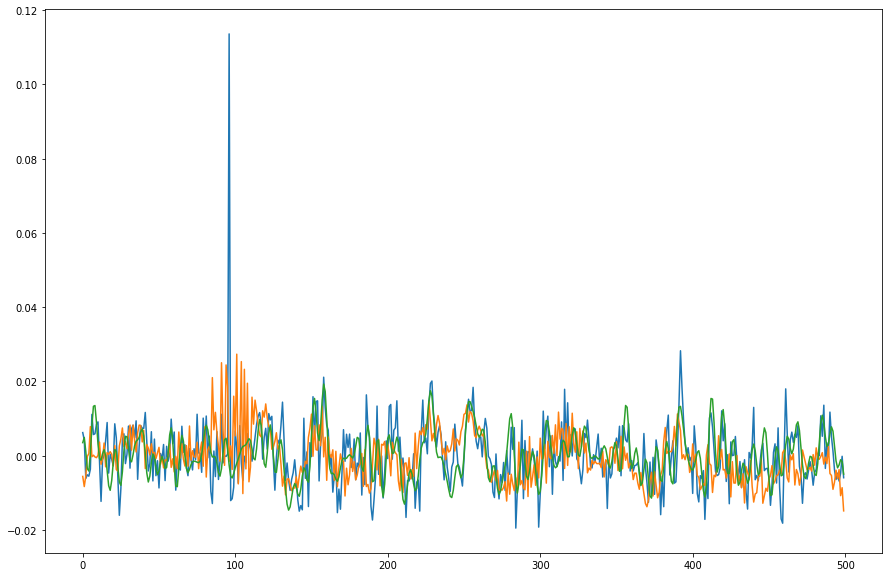

In [31]:
plt.figure(figsize=(15,10))

sl = slice(4000,4500)

yy = y.detach().numpy().flatten()


plt.plot(x.flatten()[sl])
plt.plot(yy[sl] - yy.mean())

plt.plot(d.flatten()[sl])

In [32]:
x

tensor([ 0.1593, -0.0115, -0.0162,  ...,  0.0192, -0.0020,  0.0138])

In [33]:
import IPython.display as ipd

In [34]:
display(ipd.Audio(d, rate=sr));

In [35]:
display(ipd.Audio(x.squeeze(), rate=sr));

In [36]:
display(ipd.Audio(y.detach().numpy().flatten(), rate=sr));

In [40]:
class M(nn.Module):
    def __init__(self):
        super().__init__()
        W = 64
        self.convs = [None] * 16
        self.convs[0] = nn.Conv1d(in_channels=1, out_channels=W, kernel_size=3, stride=1, padding=1, bias=True, dilation=1)
        for i in range(13):
            self.convs[i + 1] = nn.Conv1d(in_channels=W, out_channels=W, kernel_size=3, stride=1, padding=2**i, bias=True, dilation=2**i)
        self.convs[13] = nn.Conv1d(in_channels=W, out_channels=W, kernel_size=3, stride=1, padding=1, bias=True, dilation=1)
        self.convs[14] = nn.Conv1d(in_channels=W, out_channels=W, kernel_size=3, stride=1, padding=1, bias=True, dilation=1)
        self.convs[15] = nn.Conv1d(in_channels=15*W, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True, dilation=1)
        self.list = nn.ModuleList(self.convs)

    def forward(self, x):
        outs = [None] * 15
        for i in range(15):
            outs[i] = self.convs[i](x)
        y = torch.cat(outs, 1)
        return y
m = M()

In [41]:
m

M(
  (list): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (8): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
    (10): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(512,), dilation=(512,))
    (11): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding

In [42]:
summary(m, (1, 100))

RuntimeError: Given groups=1, weight of size [64, 64, 3], expected input[2, 1, 100] to have 64 channels, but got 1 channels instead

In [ ]:
torch.cat()